<a href="https://colab.research.google.com/github/gunjanak/Reinforcement_Learning/blob/main/double_dqn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In double DQNs, we use a separate network to estimate the target rather than the
prediction network. The separate network has the same structure as the prediction
network. And its weights are fixed for every T episode (T is a hyperparameter we can tune),
which means they are only updated after every T episode. The update is simply done by
copying the weights of the prediction network. In this way, the target function is fixed for a
while, which results in a more stable training process.

Mathematically, double DQNs are trained to minimize the following error term:

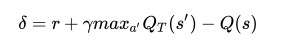

Here, s' is the resulting state after taking action, a, in state s; r is the associated reward; α is
the learning rate; and γ is the discount factor. Also,Q_T
is the function for the target network,
and Q is the function for the prediction network.

In [ ]:
#Import the library
import gym
import torch

from collections import deque
import random

import copy
from torch.autograd import Variable

In [ ]:
torch.manual_seed(0)
#connecting python script to gpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'
env = gym.envs.make("MountainCar-v0")

In [ ]:
#Class for Deep Q Network with target network along with experience replay


class DQN():
    def __init__(self, n_state, n_action, n_hidden=50, lr=0.05):
        self.criterion = torch.nn.MSELoss()
        self.model = torch.nn.Sequential(
                        torch.nn.Linear(n_state, n_hidden),
                        torch.nn.ReLU(),
                        torch.nn.Linear(n_hidden, n_hidden),
                        torch.nn.ReLU(),
                        torch.nn.Linear(n_hidden, n_action)
                       
                )


        self.model_target = copy.deepcopy(self.model)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)

    def update(self, s, y):
        """
        Update the weights of the DQN given a training sample
        @param s: state
        @param y: target value
        """
        y_pred = self.model(torch.Tensor(s))
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def predict(self, s):
        """
        Compute the Q values of the state for all actions using the learning model
        @param s: input state
        @return: Q values of the state for all actions
        """
        with torch.no_grad():
            return self.model(torch.Tensor(s))

    def target_predict(self, s):
        """
        Compute the Q values of the state for all actions using the target network
        @param s: input state
        @return: targeted Q values of the state for all actions
        """
        with torch.no_grad():
            return self.model_target(torch.Tensor(s))

    def replay(self, memory, replay_size, gamma):
        """
        Experience replay with target network
        @param memory: a list of experience
        @param replay_size: the number of samples we use to update the model each time
        @param gamma: the discount factor
        """
        if len(memory) >= replay_size:
            replay_data = random.sample(memory, replay_size)

            states = []
            td_targets = []
            for state, action, next_state, reward, is_done in replay_data:
                states.append(state)
                q_values = self.predict(state).tolist()
                if is_done:
                    q_values[action] = reward
                else:
                    q_values_next = self.target_predict(next_state).detach()

                    q_values[action] = reward + gamma * torch.max(q_values_next).item()

                td_targets.append(q_values)

            self.update(states, td_targets)

    def copy_target(self):
        self.model_target.load_state_dict(self.model.state_dict())


In [ ]:
#The Epsilon Greedy Policy
def gen_epsilon_greedy_policy(estimator, epsilon, n_action):
    def policy_function(state):
        if random.random() < epsilon:
            return random.randint(0, n_action - 1)
        else:
            q_values = estimator.predict(state)
            return torch.argmax(q_values).item()
    return policy_function

In [ ]:
#The deep Q Learning Function
def q_learning(env, estimator, n_episode, replay_size, target_update=10, gamma=1.0, epsilon=0.1,epsilon_decay=.99):
    """
    Deep Q-Learning using double DQN, with experience replay
    @param env: Gym environment
    @param estimator: DQN object
    @param replay_size: number of samples we use to update the model each time
    @param target_update: number of episodes before updating the target network
    @param n_episode: number of episodes
    @param gamma: the discount factor
    @param epsilon: parameter for epsilon_greedy
    @param epsilon_decay: epsilon decreasing factor
    """
    count = 0
   
    for episode in range(n_episode):

        if episode % target_update == 0:
            estimator.copy_target()

        policy = gen_epsilon_greedy_policy(estimator, epsilon, n_action)
        state = env.reset()
        is_done = False

        while not is_done:

            action = policy(state)
            next_state, reward, is_done, _ = env.step(action)

            total_reward_episode[episode] += reward

          

            memory.append((state, action, next_state, reward, is_done))

            if is_done:
                break

            estimator.replay(memory, replay_size, gamma)

            state = next_state
        total_reward.append(total_reward_episode[episode])
        
       

        
        print('Episode: {}, total reward: {}, epsilon: {}'.format(episode, total_reward_episode[episode], epsilon))
        if(total_reward_episode[episode] > -200):
          count = count +  1
   

        epsilon = max(epsilon * epsilon_decay, 0.01)
    print(count)

In [ ]:
#Parameters and hyperparameters
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
n_hidden = 50
lr = 0.01

In [ ]:
#Instatiation of the DQN object
dqn = DQN(n_state, n_action, n_hidden, lr)

In [ ]:
memory = deque(maxlen=10000)
n_episode = 2000
replay_size = 20
target_update = 10
total_reward_episode = [0] * n_episode
total_reward = []

#Calling the Q learning Function
q_learning(env, dqn, n_episode, replay_size, target_update, gamma=1, epsilon=0.1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)


Episode: 0, total reward: -200.0, epsilon: 0.1
Episode: 1, total reward: -200.0, epsilon: 0.099
Episode: 2, total reward: -200.0, epsilon: 0.09801
Episode: 3, total reward: -200.0, epsilon: 0.0970299
Episode: 4, total reward: -200.0, epsilon: 0.096059601
Episode: 5, total reward: -200.0, epsilon: 0.09509900499
Episode: 6, total reward: -200.0, epsilon: 0.0941480149401
Episode: 7, total reward: -200.0, epsilon: 0.093206534790699
Episode: 8, total reward: -200.0, epsilon: 0.09227446944279201
Episode: 9, total reward: -200.0, epsilon: 0.09135172474836409
Episode: 10, total reward: -200.0, epsilon: 0.09043820750088044
Episode: 11, total reward: -200.0, epsilon: 0.08953382542587164
Episode: 12, total reward: -200.0, epsilon: 0.08863848717161292
Episode: 13, total reward: -200.0, epsilon: 0.08775210229989679
Episode: 14, total reward: -200.0, epsilon: 0.08687458127689782
Episode: 15, total reward: -200.0, epsilon: 0.08600583546412884
Episode: 16, total reward: -200.0, epsilon: 0.085145777109

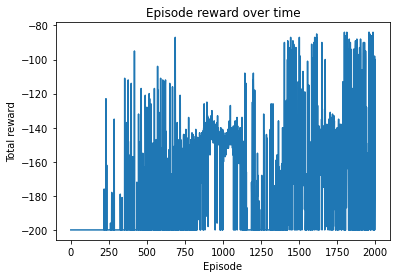

In [ ]:
#PLotting the rewards over time
import matplotlib.pyplot as plt
plt.plot(total_reward_episode)
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()

In [ ]:
#Using the trained estimator to run one episode of the MountainCar
state = env.reset()
is_done = False
total_reward_episode = 0
while not is_done:
  q_values = dqn.predict(state)
  #print(q_values)
  best_action = torch.argmax(q_values).item()
  #print(best_action)
  next_state, reward, is_done, _ = env.step(best_action)
  state = next_state
  total_reward_episode += reward


print(total_reward_episode)

-200.0


In [ ]:
episodes = 1000
total_reward = []
count = 0
for episode in range(episodes):
  #Using the trained estimator to run one episode of the MountainCar
  state = env.reset()
  is_done = False
  total_reward_episode = 0
  while not is_done:
    q_values = dqn.predict(state)
    #print(q_values)
    best_action = torch.argmax(q_values).item()
    #print(best_action)
    next_state, reward, is_done, _ = env.step(best_action)
    state = next_state
    total_reward_episode += reward


  #print(total_reward_episode)
  if(total_reward_episode > -200):
    count = count + 1
  total_reward.append(total_reward_episode)

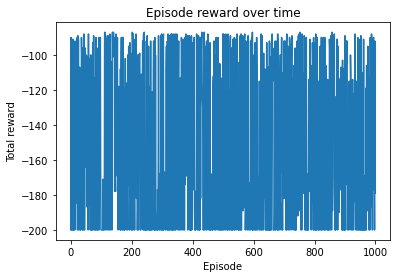

In [ ]:
plt.plot(total_reward)
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()

In [ ]:
count

682

In [ ]:
sum(total_reward)/episodes

-152.827

In [ ]:
#Saving the dqn object for future use
import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as outp:
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)
save_object(dqn, 'double_dqn_colab.pkl')